In [206]:
import numpy as np

def exp_schedule(k=20, lam=0.005, limit=100):
    function = lambda t: (k * np.exp(-lam*t) if t <limit else 0)
    return function


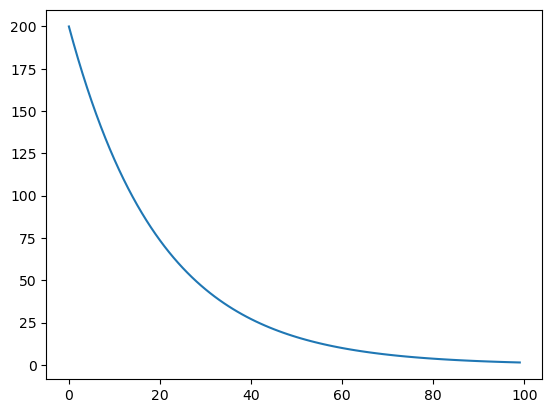

In [207]:
import matplotlib.pyplot as plt
schedule = exp_schedule(200,0.05,10000)
T = [schedule(k) for k in range(100)]
plt.plot(T)

In [208]:
import networkx as nx
import random
from smart_mobility_utilities.common import probability
from tqdm.notebook import tqdm
import osmnx as ox

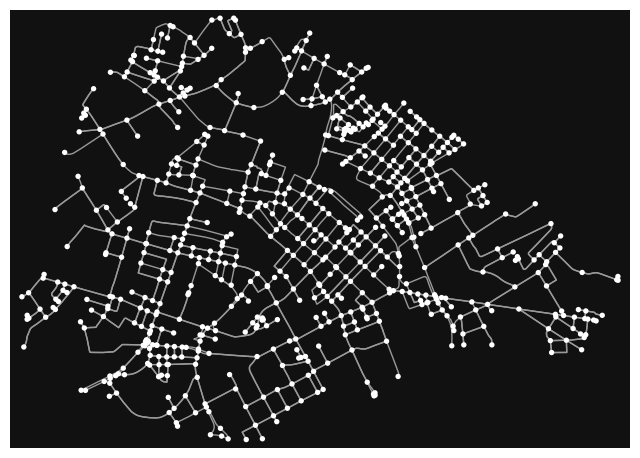

30891675
347454437


In [209]:
G = ox.graph_from_place('City Centre, Manchester, UK', network_type='drive', retain_all=False)

ox.plot_graph(G)
picadilly = ox.distance.nearest_nodes(G,-2.2312,53.4774)
oxford = ox.distance.nearest_nodes(G,-2.2422,53.4741)
print(oxford)
print(picadilly)

In [210]:
def cost_of_tour(G, tour):
    cost = 0
    

    for u,v in zip(tour, tour[1:]):
        path = nx.shortest_path(G, u,v, weight='length')
        weight = nx.path_weight(G,path, weight="length")
        cost += weight
        last_node = tour[len(tour) - 1]
        first_node = tour[0]
        path1 = nx.shortest_path(G, first_node,last_node, weight='length')
        weight1 = nx.path_weight(G,path1, weight="length")
        cost += weight1
       
    return cost

In [211]:
def full_path(G, tour):
    path_1 = []

    for u,v in zip(tour, tour[1:]):
         path = nx.shortest_path(G, u,v, weight='length')
         path_1.append(path)

    path2 = nx.shortest_path(G, tour[-1],tour[0], weight='length')
    path_1.append(path2)
    return path_1

In [212]:
# A function to generate neighbours and select a route
def get_neighbours(G,tour):
    # generate 5 more paths to choose from
        neighbours = list()
        for _ in range(5):
            child = tour[:]
            i = random.randint(0, len(child) - 1)
            j = random.randint(0, len(child) - 1)
            child[i], child[j] = child[j], child[i]
            neighbours.append(child)
        
        return random.choice(neighbours)

In [213]:
def simulated_annealing(
    G, initial_solution, num_iter, schedule_function, neighbour_function, cost_function, use_tqdm=True
):
    
    
    current = initial_solution
    states = [cost_function(G,initial_solution)]
    if use_tqdm: pbar = tqdm(total=num_iter)
    for t in range(num_iter):
        if use_tqdm: pbar.update()
        T = schedule_function(t)
        next_choice = neighbour_function(G,current)
        current_cost = cost_function(G, current)
        next_cost = cost_function(G, next_choice)
        delta_e = next_cost - current_cost
        if delta_e < 0 or probability(np.exp(-1 * delta_e / T)):
            current = next_choice
        states.append((cost_function(G,current)))

    return current, cost_function(G,current), states

Initial Solution: [347454437, 30891675, 4833840, 5774104183]
Initial Cost: 7847.370000000001


  0%|          | 0/500 [00:00<?, ?it/s]

Best Solution :[30891675, 347454437, 5774104183, 4833840]
Best Cost: 5669.335


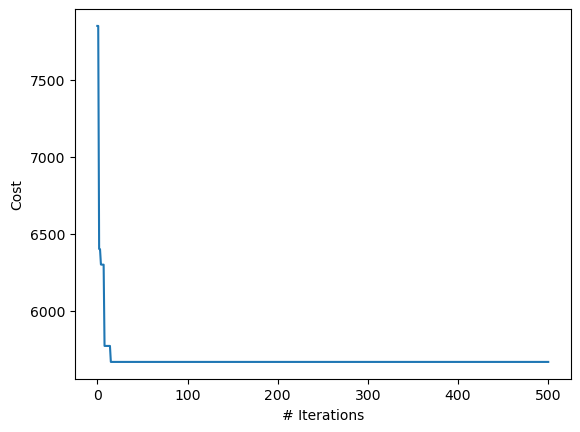

In [214]:
# # Define the annealing schedule
num_of_iterations = 500

picadilly = ox.distance.nearest_nodes(G,-2.2312,53.4774)
oxford = ox.distance.nearest_nodes(G,-2.2422,53.4741)
library = ox.distance.nearest_nodes(G,-2.244666,53.478062)
MOSI = ox.distance.nearest_nodes(G,-2.25333232,53.472831442)

all_nodes = [picadilly,oxford,library,MOSI]


initial_solution = all_nodes

print(f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost_of_tour(G,initial_solution)}")
best_solution, best_cost, states = simulated_annealing(
    G, initial_solution, num_of_iterations, schedule, get_neighbours, cost_of_tour
)
fullPath = full_path(G,best_solution)
print(f"Best Solution :{best_solution}")
print(f"Best Cost: {best_cost}")

plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.plot(states)
plt.show()

In [215]:

def get_center(G):
    undir = G.to_undirected()
    length_func = nx.single_source_dijkstra_path_length
    sp = {source: dict(length_func(undir, source, weight="length")) for source in G.nodes}
    eccentricity = nx.eccentricity(undir,sp=sp)
    center_osmid = nx.center(undir,e=eccentricity)[0]
    return center_osmid

In [216]:

import ipyleaflet as lf
import folium as fl
zoom = 15
force_leaflet=False

route = fullPath[0]

center_osmid = get_center(G)
G_gdfs = ox.graph_to_gdfs(G)
nodes_frame = G_gdfs[0]
ways_frame = G_gdfs[1]

center_node = nodes_frame.loc[center_osmid]
location = (center_node['y'], center_node['x'])

m = lf.Map(center = location, zoom = zoom)


for item in fullPath:
    route = item
    start_node = nodes_frame.loc[route[0]]
    end_node = nodes_frame.loc[route[len(route)-1]]

    start_xy = (start_node['y'], start_node['x'])
    end_xy = (end_node['y'], end_node['x'])


    if len(route) >= 500 and not force_leaflet:
        print(f"The route has {len(G)} elements, using folium to improve performance.")
        m = ox.plot_route_folium(G = G, route = route, zoom= zoom, color='red')
        fl.Marker(location=start_xy).add_to(m)
        fl.Marker(location=end_xy).add_to(m)
        
    marker = lf.Marker(location = start_xy, draggable = False)
    m.add_layer(marker)
    marker = lf.Marker(location = end_xy, draggable = False)
    m.add_layer(marker)

    for u, v in zip(route[0:], route[1:]):
        
        try:
            geo = (ways_frame.query(f'u == {u} and v == {v}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        except:
            geo = (ways_frame.query(f'u == {v} and v == {u}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        x, y = m_geo.coords.xy
        points = map(list, [*zip([*y],[*x])])
        ant_path = lf.AntPath(
            locations = [*points], 
            dash_array=[1, 10],
            delay=1000,
            color='red',
            pulse_color='black'
        )
        m.add_layer(ant_path)

 
m


u,v=(30891675, 9117250655)
u,v=(9117250655, 1674299623)
u,v=(1674299623, 931785441)
u,v=(931785441, 931785451)
u,v=(931785451, 3758438666)
u,v=(3758438666, 1687140461)
u,v=(1687140461, 1317836727)
u,v=(1317836727, 889528202)
u,v=(889528202, 9871154956)
u,v=(9871154956, 3450923)
u,v=(3450923, 290428116)
u,v=(290428116, 4839347)
u,v=(4839347, 889325537)
u,v=(889325537, 3590411971)
u,v=(3590411971, 1674309246)
u,v=(1674309246, 4284025900)
u,v=(4284025900, 347454437)
u,v=(347454437, 1674311001)
u,v=(1674311001, 1681211395)
u,v=(1681211395, 1984494903)
u,v=(1984494903, 1984494913)
u,v=(1984494913, 1681233030)
u,v=(1681233030, 3450925)
u,v=(3450925, 3450923)
u,v=(3450923, 9871154956)
u,v=(9871154956, 889528202)
u,v=(889528202, 1317836727)
u,v=(1317836727, 1687140461)
u,v=(1687140461, 3758438666)
u,v=(3758438666, 931785451)
u,v=(931785451, 931785441)
u,v=(931785441, 1674299623)
u,v=(1674299623, 9117250655)
u,v=(9117250655, 30891675)
u,v=(30891675, 1683196110)
u,v=(1683196110, 1681265900)
u,v=

Map(center=[53.4778068, -2.2406367], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…